In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyscqed import *
from pyscqed import physical_constants as pc

## Fluxonium Qubit Example

Here we will replicate the results presented [here](https://arxiv.org/abs/2111.13504) by Alibaba Group.

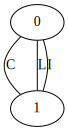

In [2]:
graph = CircuitGraph()
graph.addBranch(0, 1, "C")
graph.addBranch(0, 1, "L")
graph.addBranch(0, 1, "I")
graph.coupleResonatorCapacitively(1, "Cc")
graph.drawGraphViz()

In [3]:
circuit = SymbolicSystem(graph)
circuit.getQuantumHamiltonian()

Flux bias term phi10-2e is on edge (1, 0, 2) (I).
Flux bias term phi10-2e is on edge (1, 0, 2) (I).
Optimal basis representations for the circuit coordinates:
{1: 'oscillator'}


Matrix([[-0.5*I_{}*(exp(1.0*I*\phi_{10-2e})*D_{1} + exp(-1.0*I*\phi_{10-2e})*D^{\dagger}_{1}) + 0.5*\Phi_{1}**2/L_{} + 0.5*Q_{1}**2/C_{00}]])

### Qubit A

We will first reproduce Fig 1(c). See Table S1 for the parameter values.

In [4]:
# Define the qubit parameters and resonator frequency
EcA = 1.398e9
ElA = 0.523e9*0.5
EjA = 2.257e9
frA = 6.696 # GHz
ZrA = 50.0

In [5]:
# We'll assume that Cc is approximately zero and see what we get first
C = 0.5*pc.e**2/(pc.h*EcA)
print(C*1e15, "fF")

13.855671893925317 fF


In [6]:
# Inductance energy is simple
L = 0.5*pc.phi0**2/(pc.h*ElA*4*np.pi**2)
print(L*1e12, "pH") # Large inductance

312545.91349847504 pH


In [7]:
# Josephson junction critical current
I = 2*np.pi*pc.h*EjA/(pc.phi0)
print(I*1e6, "uA") # Very small J energy

0.004544141153511146 uA


Here we must use the oscillator (or flux) basis rather than the charge basis, as the inductive term will play an important role in the potential energy. We'll use a truncation of 101 states.

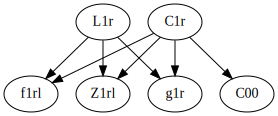

In [8]:
circuit.drawParameterisationGraph()

In [9]:
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 101, "oscillator")
hamil.setParameterValues(
    "C", C*1e15-0.3, # In fF
    "I", I*1e6, # In uA
    "L", L*1e12, # In pH
    "Cc", 0.3,
    "f1r", frA,
    "Z1r", ZrA,
    "phi10-2e", 0.5
)

Creating PyCQED tmp output root directory 'C:\Users\LFRYBO~1\AppData\Local\Temp\.pycqed\'.


Verify what we get for the energies using these circuit parameters

In [10]:
hamil.getChargingEnergies(1)/4

1.3980190905899303

In [11]:
hamil.getFluxEnergies(1)

10.323606203539468

In [12]:
hamil.getJosephsonEnergies((1, 0, 2))

2.257

For the transition frequencies we'll use qutips method on the underlying Qobj:

In [13]:
E = hamil.getHamiltonian().eigenenergies()

In [14]:
print("w10/2pi =", E[1] - E[0])
print("w21/2pi =", E[2] - E[1])

w10/2pi = 1.057503263758758
w21/2pi = 3.0632816389342987


We see the parameters we get are pretty close to what they have reported. The discrepancy is likely due to the inexact value of inductance and the details of their model implementation, for example the size of their truncation could play role.

In [15]:
# Configure the sweep
hamil.addSweep('phi10-2e', 0.25, 0.6, 101)
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.018 s
  Loop duration:	0.800 s
  Avg iteration:	0.008 s


(0.0, 8.0)

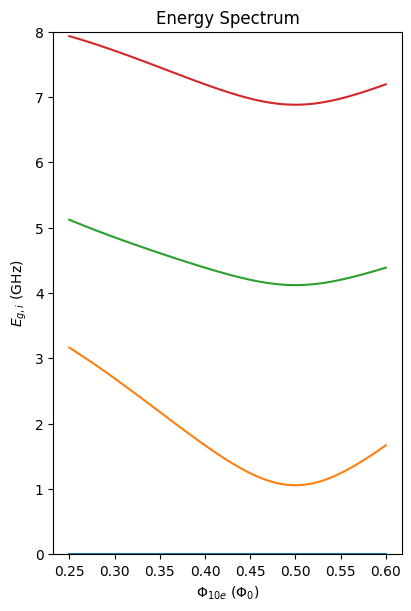

In [16]:
# Get the sweep for a high value of Ic
x, phi10e_sweep, v = hamil.getSweep(sweep, 'phi10-2e', {})

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 6))

# Energy spectrum
for i in range(5):
    y = phi10e_sweep[i]-phi10e_sweep[0]
    ax.plot(x,y)
ax.set_xlabel("$\Phi_{10e}$ ($\Phi_0$)")
ax.set_ylabel("$E_{g,i}$ (GHz)")
ax.set_title("Energy Spectrum")
ax.set_ylim(0, 8)
#ax.set_xlim(0.49, 0.51)

As we can see the data looks fairly consistent with their figure.

### Resonator and Dispersive Shift

Now let's see what they might have observed in terms of resonator response from flux modulation:

In [17]:
# Looking at the qubit-resonator coupling energy,
# it is complicated, so we can adjust Cc to get what we need
circuit.getParametricExpression('g1r')

624.464051555112*C_{c}/((L_{1r}*(C_{c} + C_{})/(-C_{c}**2 + (C_{1r} + C_{c})*(C_{c} + C_{})))**(1/4)*(-C_{c}**2 + (C_{1r} + C_{c})*(C_{c} + C_{})))

In [18]:
# Configure the parameter sweep
hamil.newSweep()
hamil.addSweep('phi10-2e', -1.0, 1.0, 201)

# Configure the items to be evaluated
hamil.addEvaluation('Hamiltonian'),
hamil.addEvaluation('Resonator', cpl_node=1)

# Configure diagonaliser to give us eigenvectors
hamil.setDiagConfig(get_vectors=True, eigvalues=20)

# Do the sweep
sweep = hamil.paramSweep(timesweep=True)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Let's look at the dressed qubit spectrum first

In [19]:
# Get the design and loaded resonator frequencies
fr = hamil.getParameterValue('f1r')
frl = hamil.getParameterValue('f1rl')

x,Erwa,v = hamil.getSweep(sweep,'phi10-2e',{},evaluable='Resonator')
Edressed = util.getCircuitLambShift(Erwa)

Text(0.5, 1.0, '(Loaded) Dressed Coupler Energy Spectrum')

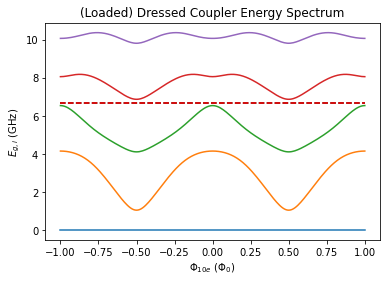

In [20]:
# Dressed energy spectrum
for i in range(5):
    y = Edressed[i]
    plt.plot(x,y)
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("(Loaded) Dressed Coupler Energy Spectrum")

We shouldn't see any avoided crossings here as the qubit energy never crosses the resonator energy. We do see however that near $\Phi_{10e} = 0.5 \Phi_0$, the resonator will be strongly coupled to the 3rd excited state of the qubit as pointed out in the text.

Let's first look at the single cavity photon resonator shifts when the qubit is in the ground state:

In [21]:
# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

Text(0.5, 1.0, 'Resonator Modulation Against $Q_{1e}$')

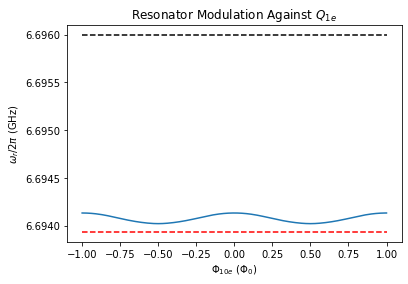

In [22]:
plt.plot(x,Eres[0,0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}/2\pi$ (GHz)")
plt.title("Resonator Modulation Against $Q_{1e}$")

And when the qubit is in the first excited state:

Text(0.5, 1.0, 'Resonator Modulation Against $Q_{1e}$')

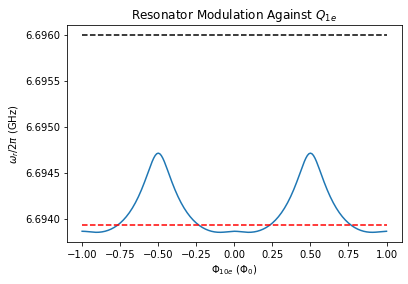

In [23]:
plt.plot(x,Eres[1, 0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.plot([x[0], x[-1]], [frl, frl], "r--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}/2\pi$ (GHz)")
plt.title("Resonator Modulation Against $Q_{1e}$")

The single-photon dispersive shift $\chi$ due to transitions between the ground and first excited states will then simply be:

Text(0.5, 1.0, 'Resonator Modulation Against $Q_{1e}$')

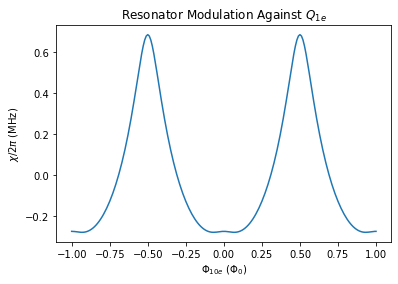

In [24]:
plt.plot(x, (Eres[1, 0] - Eres[0, 0])*1e3)
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\chi/2\pi$ (MHz)")
plt.title("Resonator Modulation Against $Q_{1e}$")

Indeed this appears to be close to the value report of 0.63 MHz.

### Coupling Energy

Now we'll reproduce the avoided crossing due to coupling between qubits A and B.

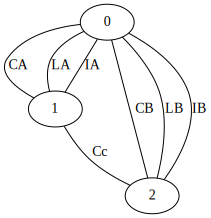

In [25]:
graph = CircuitGraph()
graph.addBranch(0, 1, "CA")
graph.addBranch(0, 1, "LA")
graph.addBranch(0, 1, "IA")
graph.addBranch(0, 2, "CB")
graph.addBranch(0, 2, "LB")
graph.addBranch(0, 2, "IB")
graph.addBranch(1, 2, "Cc")
graph.drawGraphViz()

In [26]:
circuit = SymbolicSystem(graph)
circuit.getQuantumHamiltonian()

Flux bias term phi10-2e is on edge (1, 0, 2) (IA).
Flux bias term phi20-2e is on edge (2, 0, 2) (IB).
Optimal basis representations for the circuit coordinates:
{1: 'oscillator', 2: 'oscillator'}


Matrix([[-0.5*I_{A}*(exp(1.0*I*\phi_{10-2e})*D_{1} + exp(-1.0*I*\phi_{10-2e})*D^{\dagger}_{1}) - 0.5*I_{B}*(exp(1.0*I*\phi_{20-2e})*D_{2} + exp(-1.0*I*\phi_{20-2e})*D^{\dagger}_{2}) + (0.5*C_{00i}*Q_{1} + 0.5*C_{01i}*Q_{2})*Q_{1} + (0.5*C_{01i}*Q_{1} + 0.5*C_{11i}*Q_{2})*Q_{2} + 0.5*\Phi_{2}**2/L_{B} + 0.5*\Phi_{1}**2/L_{A}]])

The capacitive coupling energy between qubits A and B will be determined by the off-diagonal elements of the inverse capacitance matrix:

In [27]:
# Define the qubit parameters and resonator frequency
EcA = 1.398e9
ElA = 0.523e9*40*0.5
EjA = 2.257e9
EcB = 1.572e9
ElB = 0.537e9*40*0.5
EjB = 2.086e9

CA = 0.5*pc.e**2/(pc.h*EcA)
CB = 0.5*pc.e**2/(pc.h*EcB)
LA = 0.5*pc.phi0**2/(pc.h*ElA)
LB = 0.5*pc.phi0**2/(pc.h*ElB)
IA = 2*np.pi*pc.h*EjA/(pc.phi0)
IB = 2*np.pi*pc.h*EjB/(pc.phi0)

hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 31, "oscillator")
hamil.configureOperator(2, 31, "oscillator")
hamil.setParameterValues(
    "CA", CA*1e15, # In fF
    "CB", CB*1e15, # In fF
    "IA", IA*1e6, # In uA
    "IB", IB*1e6, # In uA
    "LA", LA*1e12, # In pH
    "LB", LB*1e12, # In pH
    "Cc", 1.0,
    "phi10-2e", 0.5,
    "phi20-2e", 0.5
)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


To reproduce the data shown in Figure 1(e), we'll set $\Phi_{20e} = 0.5 \Phi_0$ and sweep only $\Phi_{10e}$:

In [28]:
# Configure the sweep
hamil.addSweep('phi10-2e', 0.4, 0.5, 101)
sweep = hamil.paramSweep(timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.476 s
  Loop duration:	78.328 s
  Avg iteration:	0.776 s


(1.15, 1.3)

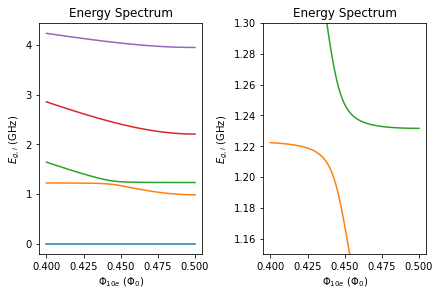

In [29]:
# Get the sweep for a high value of Ic
x, phi10e_sweep, v = hamil.getSweep(sweep, 'phi10-2e', {})

fig, ax = plt.subplots(1, 2, constrained_layout=True)

# Energy spectrum
for i in range(5):
    y = phi10e_sweep[i]-phi10e_sweep[0]
    ax[0].plot(x,y)
ax[0].set_xlabel("$\Phi_{10e}$ ($\Phi_0$)")
ax[0].set_ylabel("$E_{g,i}$ (GHz)")
ax[0].set_title("Energy Spectrum")
#ax[0].set_ylim(0.5, 2)
#ax[0].set_xlim(0.49, 0.51)

# Energy spectrum
for i in range(5):
    y = phi10e_sweep[i]-phi10e_sweep[0]
    ax[1].plot(x,y)
ax[1].set_xlabel("$\Phi_{10e}$ ($\Phi_0$)")
ax[1].set_ylabel("$E_{g,i}$ (GHz)")
ax[1].set_title("Energy Spectrum")
ax[1].set_ylim(1.15, 1.3)
#ax[1].set_xlim(0.49, 0.51)

We see that we get a coupling $g$ on the order of 20 MHz in a a similar place to what Alibaba observed. We could slightly reduce the capacitor $C_c$ but this is close enough.